In [118]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


# Libraries

In [119]:
# torch stuff
import torch
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

# needed for model
from math import log2
from tqdm import tqdm
import random
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import torchvision
from torchvision.utils import save_image

# ProGAN Variables

In [120]:
# scaling of blocks
factors = [1, 1, 1/2, 1/4, 1/8]
# this is what ProGAN starts generating, not actual image size
starting_img_size = 4
datapath= "/home/dsu/Desktop/Projects/FinalProject/cat_imgs"

gen_save_path = "generator.pth"
dis_save_path = "discriminator.pth"

if(torch.cuda.is_available()):
    device = "cuda"
else:
    print("Warning! Using CPU!")
    device = "cpu"

# If load_model is False, model will train. 
# If load_model is true, no training will happen, only display generated images
save_model = True
load_model = False

lr = 1e-3
layer_batch_size = [16, 16, 16, 16, 8]

noise_dim = 100
img_size = 64
channels = 3

layer_epochs = [30] * len(layer_batch_size)

# Create ProGAN Pieces

In [121]:
# Weight Scaled Conv2d
# This is required for the progan, as the transition from different resolutions will
# affect the gradients (4x4 to 8x8, for example)
class WSConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, gain=2):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (gain / (in_channels * kernel_size ** 2)) ** 0.5
        # bias should not be scaled
        self.bias = self.conv.bias
        self.conv.bias = None

        # init conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

In [122]:
class PixelNorm(nn.Module):
    # replacement for batch norm, needed because different size outputs must be normed properly
    def __init__(self):
        super(PixelNorm, self).__init__()
        # avoid division by 0 error
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True) + self.epsilon)

In [123]:
# Block layers for scaling up or down the images to different resolutions
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.relu = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()
        self.use_pn = pixelnorm

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        if(self.use_pn):
            x = self.pn(x)
        x = self.conv2(x)
        x = self.relu(x)
        if(self.use_pn):
            x = self.pn(x)
        return x

# Generator

In [124]:
class Generator(nn.Module):
    def __init__(self, noise_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()
        # scale 1x1 to 4x4, just like in the progan paper
        # need this before beginning convolutions
        self.initial = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(noise_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm()
        )
        # rgb block just gets it back into colored image, this is done after the final
        # block (which changes as the progan is trained) and is used for fade in
        self.initial_rgb = WSConv2d(in_channels, img_channels, kernel_size=1, stride=1, padding=0)

        # create the actual generator blocks and rgb layers
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([self.initial_rgb])

        # for each factor, create a scaled block
        # paper has repeated blocks of 512 before halfing each time, hense the 1's in factor
        for i in range(len(factors) - 1):
            conv_in_chan = int(in_channels * factors[i])
            conv_out_chan = int(in_channels * factors[i+1])
            self.prog_blocks.append(ConvBlock(conv_in_chan, conv_out_chan))
            self.rgb_layers.append(WSConv2d(conv_out_chan, img_channels, kernel_size=1, stride=1, padding=0))

    # get inbetween representation (alpha is fade-in strength)
    def fade_in(self, alpha, upscaled, generated):
        return torch.tanh(alpha * generated + (1-alpha) * upscaled)
    
    def forward(self, x, alpha, steps):
        # for each step, increase size. 0:4x4, 1:8x8, ... 4:64x64
        out = self.initial(x)

        if(steps == 0):
            # if steps is 0, just return the rgb representation of the 4x4
            return self.initial_rgb(out)
        
        for step in range(steps):
            # upsample, then run through blocks
            upsample = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upsample)

        # use the rgb layer before so that it gets the rgb from the last step
        # if currently on 32x32, this gets 16x16 so the fade-in process can happen
        upsample_final = self.rgb_layers[steps-1](upsample)
        output_final = self.rgb_layers[steps](out)

        return self.fade_in(alpha, upsample_final, output_final)

# Discriminator

In [125]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        # create prog blocks (reverse order from discriminator)
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.relu = nn.LeakyReLU(0.2)

        # go backwards from factors until you reach 0
        for i in range(len(factors) - 1, 0, -1):
            conv_in_chan = int(in_channels * factors[i])
            conv_out_chan = int(in_channels * factors[i-1])
            self.prog_blocks.append(ConvBlock(conv_in_chan, conv_out_chan, pixelnorm=False))
            self.rgb_layers.append(WSConv2d(img_channels, conv_in_chan, kernel_size=1, stride=1, padding=0))

        # this is a conversion from the 4x4 image
        self.final_rgb = WSConv2d(img_channels, in_channels, kernel_size=1, stride=1, padding=0)
        self.rgb_layers.append(self.final_rgb)
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)

        # no flatten/dense needed if you are smart about it
        self.final_block = nn.Sequential(
            WSConv2d(in_channels+1, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, stride=1, padding=0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, 1, kernel_size=1, stride=1, padding=0)
        )

    def fade_in(self, alpha, downsampled, out):
        return alpha * out + (1 - alpha) * downsampled

    def minibatch_std(self, x):
        # gets std dev for every x, goes for a single value, that repeated
        # this can smooth the trainsition between resolutions
        batch_stats = torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3]) # example given: N x C x H x W -> N
        return torch.cat([x, batch_stats], dim=1) # goes from 512 to 513 in paper

    def forward(self, x, alpha, steps):
        # since the prog_blocks list is inverted in the discriminator, we want the last
        # block when we are on the final step, so invert steps to get this
        cur_step = len(self.prog_blocks) - steps
        out = self.relu(self.rgb_layers[cur_step](x))

        if(steps == 0):
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)
        
        # fade in done in the end of a generator step, so it must be done in the
        # beginning of the discriminator step
        # refer to image in paper, this is complicated
        # the avg_pool represents the 0.5x of the downsampling area
        downsampled = self.relu(self.rgb_layers[cur_step+1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))
        out = self.fade_in(alpha, downsampled, out)

        # already finished first step, so
        for step in range(cur_step+1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

# Utility Functions

In [126]:
# Gradient penalty is used so that the discriminator loss won't deviate that much.
# This enforces consistent training, so that the discriminator won't learn to much or
# too little.
def gradient_penalty(discriminator, real, fake, alpha, train_step, device="cpu"):
    batch_size, chan, height, width = real.shape
    beta = torch.rand((batch_size, 1, 1, 1)).repeat(1, chan, height, width).to(device)

    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate discriminator scores
    mixed_scores = discriminator(interpolated_images, alpha, train_step)

    # Get gradient for the scores (graph needed here because of gradient penalty)
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(model, optimizer, filename="checkpoint.pth.tar"):
    print("Saving Checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict()
    }
    torch.save(checkpoint, filename)

def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("Loading Checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location="cuda")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # learning rate saved just in case training afterwards
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr


def generate_examples(gen, steps, n=100, alpha=1.0):
    gen.eval()
    for i in range(n):
        with torch.no_grad():
            noise = torch.randn(1, noise_dim, 1, 1).to(device)
            img = gen(noise, alpha, steps)
            save_image(img * 0.5 + 0.5, f'progan_examples/step_{steps}_img_{i}.png')

    gen.train()


# Training can happen now

In [127]:
# Will hopefully speedup since I'm using images of the same resolution for training
torch.backends.cudnn.benchmarks = True

# Custom batch loader since I am using variable batch sizes at each step
def get_loader(image_size):
    transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize(
                [0.5 for _ in range(channels)],
                [0.5 for _ in range(channels)]
            )
        ]
    )
    batch_size = layer_batch_size[int(log2(image_size / 4))]
    dataset = datasets.ImageFolder(root=datapath, transform=transform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )

    return loader, dataset


# Training loop
def train_loop(dis, gen, loader, dataset, step, alpha, opt_dis, opt_gen, scaler_gen, scaler_dis):
    loop = tqdm(loader, leave=True)
    for batch_index, (real, _) in enumerate(loop):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        # Train Discriminator
        noise = torch.randn(cur_batch_size, noise_dim, 1, 1).to(device)

        with torch.amp.autocast("cuda"):
            fake = gen(noise, alpha, step)
            dis_real = dis(real, alpha, step)
            dis_fake = dis(fake.detach(), alpha, step)
            gp = gradient_penalty(dis, real, fake, alpha, step, device)
            # minimize mistakes
            loss_dis = (
                -(torch.mean(dis_real) - torch.mean(dis_fake))
                + 10 * gp
                + (0.001 * torch.mean(dis_real ** 2))
            )

        opt_dis.zero_grad()
        scaler_dis.scale(loss_dis).backward()
        scaler_dis.step(opt_dis)
        scaler_dis.update()

        # Train Generator:
        with torch.amp.autocast("cuda"):
            gen_fake = dis(fake, alpha, step)
            loss_gen = -torch.mean(gen_fake)

        opt_gen.zero_grad()
        scaler_gen.scale(loss_gen).backward()
        scaler_gen.step(opt_gen)
        scaler_gen.update()

        # Fade in will start at low, move to 1 by the end of the training
        alpha += cur_batch_size / (len(dataset) * layer_epochs[step]*0.5)
        alpha = min(alpha, 1)

        # show losses in tqdm
        loop.set_postfix(
            gp=gp.item(),
            loss_dis=loss_dis.item(),
        )

    return alpha

In [128]:
# models
gen = Generator(noise_dim, img_size, channels).to(device)
dis = Discriminator(img_size, channels).to(device)

# optimizers
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.0, 0.99))
opt_dis = optim.Adam(dis.parameters(), lr=lr, betas=(0.0, 0.99))

scaler_dis = torch.amp.GradScaler("cuda")
scaler_gen = torch.amp.GradScaler("cuda")

# load model if retraining
if(load_model):
    load_checkpoint(gen_save_path, gen, opt_gen, lr)
    load_checkpoint(dis_save_path, dis, opt_dis, lr)


if(load_model == False):
    gen.train()
    dis.train()

    step = int(log2(starting_img_size/4))

    for num_epochs in layer_epochs[step:]:
        alpha = 1e-5
        loader, dataset = get_loader(4*2**step)
        print(f"Image Size: {4*2**step}")

        for epoch in range(num_epochs):
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            alpha = train_loop(dis, gen, loader, dataset, step, alpha, opt_dis, opt_gen, scaler_gen, scaler_dis)

            if(save_model==True):
                save_checkpoint(gen, opt_gen, filename=gen_save_path)
                save_checkpoint(dis, opt_dis, filename=dis_save_path)
                generate_examples(gen, step, 20)
            

        step += 1 # next step

Image Size: 4
Epoch [1/30]


  0%|          | 0/1866 [00:00<?, ?it/s]

100%|██████████| 1866/1866 [01:03<00:00, 29.26it/s, gp=0.00238, loss_dis=-0.328]  


Saving Checkpoint
Saving Checkpoint
Epoch [2/30]


100%|██████████| 1866/1866 [00:55<00:00, 33.44it/s, gp=0.00631, loss_dis=-0.101]  


Saving Checkpoint
Saving Checkpoint
Epoch [3/30]


100%|██████████| 1866/1866 [00:53<00:00, 34.74it/s, gp=0.0266, loss_dis=0.226]     


Saving Checkpoint
Saving Checkpoint
Epoch [4/30]


100%|██████████| 1866/1866 [00:56<00:00, 33.24it/s, gp=0.0115, loss_dis=0.132]     


Saving Checkpoint
Saving Checkpoint
Epoch [5/30]


100%|██████████| 1866/1866 [00:56<00:00, 33.19it/s, gp=0.0122, loss_dis=0.487]    


Saving Checkpoint
Saving Checkpoint
Epoch [6/30]


100%|██████████| 1866/1866 [00:55<00:00, 33.50it/s, gp=0.0186, loss_dis=0.28]     


Saving Checkpoint
Saving Checkpoint
Epoch [7/30]


100%|██████████| 1866/1866 [00:55<00:00, 33.69it/s, gp=0.0106, loss_dis=-0.0599]  


Saving Checkpoint
Saving Checkpoint
Epoch [8/30]


100%|██████████| 1866/1866 [00:55<00:00, 33.46it/s, gp=0.00658, loss_dis=0.0631]  


Saving Checkpoint
Saving Checkpoint
Epoch [9/30]


100%|██████████| 1866/1866 [00:55<00:00, 33.42it/s, gp=0.0104, loss_dis=0.224]    


Saving Checkpoint
Saving Checkpoint
Epoch [10/30]


100%|██████████| 1866/1866 [00:53<00:00, 34.87it/s, gp=0.0593, loss_dis=0.578]    


Saving Checkpoint
Saving Checkpoint
Epoch [11/30]


100%|██████████| 1866/1866 [00:54<00:00, 34.35it/s, gp=0.00347, loss_dis=0.0734]  


Saving Checkpoint
Saving Checkpoint
Epoch [12/30]


100%|██████████| 1866/1866 [00:55<00:00, 33.90it/s, gp=0.017, loss_dis=0.508]      


Saving Checkpoint
Saving Checkpoint
Epoch [13/30]


100%|██████████| 1866/1866 [00:55<00:00, 33.48it/s, gp=0.00186, loss_dis=-0.177]  


Saving Checkpoint
Saving Checkpoint
Epoch [14/30]


100%|██████████| 1866/1866 [00:55<00:00, 33.51it/s, gp=0.0213, loss_dis=0.0904]    


Saving Checkpoint
Saving Checkpoint
Epoch [15/30]


100%|██████████| 1866/1866 [00:58<00:00, 31.89it/s, gp=0.0281, loss_dis=0.648]     


Saving Checkpoint
Saving Checkpoint
Epoch [16/30]


100%|██████████| 1866/1866 [00:55<00:00, 33.57it/s, gp=0.00339, loss_dis=0.231]   


Saving Checkpoint
Saving Checkpoint
Epoch [17/30]


100%|██████████| 1866/1866 [00:56<00:00, 32.77it/s, gp=0.0384, loss_dis=0.618]    


Saving Checkpoint
Saving Checkpoint
Epoch [18/30]


100%|██████████| 1866/1866 [00:54<00:00, 34.47it/s, gp=0.00453, loss_dis=0.223]   


Saving Checkpoint
Saving Checkpoint
Epoch [19/30]


100%|██████████| 1866/1866 [00:59<00:00, 31.59it/s, gp=0.00738, loss_dis=0.111]    


Saving Checkpoint
Saving Checkpoint
Epoch [20/30]


100%|██████████| 1866/1866 [01:02<00:00, 30.05it/s, gp=0.000729, loss_dis=0.0816]  


Saving Checkpoint
Saving Checkpoint
Epoch [21/30]


100%|██████████| 1866/1866 [01:11<00:00, 26.24it/s, gp=0.0151, loss_dis=0.248]     


Saving Checkpoint
Saving Checkpoint
Epoch [22/30]


100%|██████████| 1866/1866 [01:10<00:00, 26.49it/s, gp=0.00113, loss_dis=-0.148]   


Saving Checkpoint
Saving Checkpoint
Epoch [23/30]


100%|██████████| 1866/1866 [01:02<00:00, 29.84it/s, gp=0.0342, loss_dis=-0.14]     


Saving Checkpoint
Saving Checkpoint
Epoch [24/30]


100%|██████████| 1866/1866 [01:04<00:00, 28.76it/s, gp=0.000921, loss_dis=0.186]  


Saving Checkpoint
Saving Checkpoint
Epoch [25/30]


100%|██████████| 1866/1866 [01:05<00:00, 28.54it/s, gp=0.00567, loss_dis=0.134]   


Saving Checkpoint
Saving Checkpoint
Epoch [26/30]


100%|██████████| 1866/1866 [01:05<00:00, 28.54it/s, gp=0.00348, loss_dis=-0.107]  


Saving Checkpoint
Saving Checkpoint
Epoch [27/30]


100%|██████████| 1866/1866 [01:07<00:00, 27.48it/s, gp=0.00634, loss_dis=0.0286]  


Saving Checkpoint
Saving Checkpoint
Epoch [28/30]


100%|██████████| 1866/1866 [01:05<00:00, 28.44it/s, gp=0.00371, loss_dis=0.0573]   


Saving Checkpoint
Saving Checkpoint
Epoch [29/30]


100%|██████████| 1866/1866 [01:06<00:00, 28.14it/s, gp=0.000737, loss_dis=0.00313] 


Saving Checkpoint
Saving Checkpoint
Epoch [30/30]


100%|██████████| 1866/1866 [01:05<00:00, 28.28it/s, gp=0.0139, loss_dis=0.419]     


Saving Checkpoint
Saving Checkpoint
Image Size: 8
Epoch [1/30]


100%|██████████| 1866/1866 [01:43<00:00, 18.10it/s, gp=0.0156, loss_dis=-0.0464]  


Saving Checkpoint
Saving Checkpoint
Epoch [2/30]


100%|██████████| 1866/1866 [01:39<00:00, 18.73it/s, gp=0.00288, loss_dis=-0.242]   


Saving Checkpoint
Saving Checkpoint
Epoch [3/30]


100%|██████████| 1866/1866 [01:40<00:00, 18.55it/s, gp=0.00481, loss_dis=-0.0593]  


Saving Checkpoint
Saving Checkpoint
Epoch [4/30]


100%|██████████| 1866/1866 [01:41<00:00, 18.43it/s, gp=0.000243, loss_dis=-0.0958] 


Saving Checkpoint
Saving Checkpoint
Epoch [5/30]


100%|██████████| 1866/1866 [01:40<00:00, 18.55it/s, gp=0.00155, loss_dis=-0.555]   


Saving Checkpoint
Saving Checkpoint
Epoch [6/30]


100%|██████████| 1866/1866 [01:35<00:00, 19.48it/s, gp=0.000271, loss_dis=0.0818]   


Saving Checkpoint
Saving Checkpoint
Epoch [7/30]


100%|██████████| 1866/1866 [01:37<00:00, 19.05it/s, gp=0.00159, loss_dis=-0.485]    


Saving Checkpoint
Saving Checkpoint
Epoch [8/30]


100%|██████████| 1866/1866 [01:35<00:00, 19.45it/s, gp=0.000915, loss_dis=0.173]    


Saving Checkpoint
Saving Checkpoint
Epoch [9/30]


100%|██████████| 1866/1866 [01:36<00:00, 19.36it/s, gp=0.000948, loss_dis=0.0886]   


Saving Checkpoint
Saving Checkpoint
Epoch [10/30]


100%|██████████| 1866/1866 [01:38<00:00, 18.89it/s, gp=0.00126, loss_dis=-0.364]    


Saving Checkpoint
Saving Checkpoint
Epoch [11/30]


100%|██████████| 1866/1866 [01:37<00:00, 19.14it/s, gp=0.000854, loss_dis=-0.238]   


Saving Checkpoint
Saving Checkpoint
Epoch [12/30]


100%|██████████| 1866/1866 [01:34<00:00, 19.72it/s, gp=0.00106, loss_dis=-0.384]    


Saving Checkpoint
Saving Checkpoint
Epoch [13/30]


100%|██████████| 1866/1866 [01:38<00:00, 18.99it/s, gp=0.00134, loss_dis=-0.208]    


Saving Checkpoint
Saving Checkpoint
Epoch [14/30]


100%|██████████| 1866/1866 [01:35<00:00, 19.63it/s, gp=0.00105, loss_dis=-0.0694]   


Saving Checkpoint
Saving Checkpoint
Epoch [15/30]


100%|██████████| 1866/1866 [01:37<00:00, 19.18it/s, gp=0.00038, loss_dis=0.227]     


Saving Checkpoint
Saving Checkpoint
Epoch [16/30]


100%|██████████| 1866/1866 [01:34<00:00, 19.74it/s, gp=0.00111, loss_dis=0.121]     


Saving Checkpoint
Saving Checkpoint
Epoch [17/30]


100%|██████████| 1866/1866 [01:35<00:00, 19.63it/s, gp=0.00279, loss_dis=0.41]      


Saving Checkpoint
Saving Checkpoint
Epoch [18/30]


100%|██████████| 1866/1866 [01:39<00:00, 18.70it/s, gp=0.00161, loss_dis=0.0969]    


Saving Checkpoint
Saving Checkpoint
Epoch [19/30]


100%|██████████| 1866/1866 [01:40<00:00, 18.59it/s, gp=0.000859, loss_dis=-0.155]  


Saving Checkpoint
Saving Checkpoint
Epoch [20/30]


100%|██████████| 1866/1866 [01:38<00:00, 18.86it/s, gp=0.00152, loss_dis=0.231]     


Saving Checkpoint
Saving Checkpoint
Epoch [21/30]


100%|██████████| 1866/1866 [01:40<00:00, 18.63it/s, gp=0.000345, loss_dis=-0.101]   


Saving Checkpoint
Saving Checkpoint
Epoch [22/30]


100%|██████████| 1866/1866 [01:39<00:00, 18.75it/s, gp=0.000616, loss_dis=0.117]    


Saving Checkpoint
Saving Checkpoint
Epoch [23/30]


100%|██████████| 1866/1866 [01:38<00:00, 19.01it/s, gp=0.000237, loss_dis=0.0167]   


Saving Checkpoint
Saving Checkpoint
Epoch [24/30]


100%|██████████| 1866/1866 [01:37<00:00, 19.20it/s, gp=0.00113, loss_dis=0.355]     


Saving Checkpoint
Saving Checkpoint
Epoch [25/30]


100%|██████████| 1866/1866 [01:37<00:00, 19.11it/s, gp=0.0012, loss_dis=-0.0412]    


Saving Checkpoint
Saving Checkpoint
Epoch [26/30]


100%|██████████| 1866/1866 [01:37<00:00, 19.19it/s, gp=0.00249, loss_dis=0.175]     


Saving Checkpoint
Saving Checkpoint
Epoch [27/30]


100%|██████████| 1866/1866 [01:41<00:00, 18.46it/s, gp=0.000906, loss_dis=0.224]    


Saving Checkpoint
Saving Checkpoint
Epoch [28/30]


100%|██████████| 1866/1866 [01:36<00:00, 19.24it/s, gp=0.000414, loss_dis=-0.0817]  


Saving Checkpoint
Saving Checkpoint
Epoch [29/30]


100%|██████████| 1866/1866 [01:38<00:00, 19.03it/s, gp=0.000513, loss_dis=0.0286]   


Saving Checkpoint
Saving Checkpoint
Epoch [30/30]


100%|██████████| 1866/1866 [01:36<00:00, 19.39it/s, gp=0.00149, loss_dis=0.0566]    


Saving Checkpoint
Saving Checkpoint
Image Size: 16
Epoch [1/30]


100%|██████████| 1866/1866 [02:00<00:00, 15.45it/s, gp=0.00194, loss_dis=-2.1]      


Saving Checkpoint
Saving Checkpoint
Epoch [2/30]


100%|██████████| 1866/1866 [01:59<00:00, 15.67it/s, gp=0.0346, loss_dis=0.44]     


Saving Checkpoint
Saving Checkpoint
Epoch [3/30]


100%|██████████| 1866/1866 [02:00<00:00, 15.51it/s, gp=0.0453, loss_dis=-1.04]     


Saving Checkpoint
Saving Checkpoint
Epoch [4/30]


100%|██████████| 1866/1866 [01:59<00:00, 15.55it/s, gp=0.0137, loss_dis=0.889]     


Saving Checkpoint
Saving Checkpoint
Epoch [5/30]


100%|██████████| 1866/1866 [01:57<00:00, 15.87it/s, gp=0.0221, loss_dis=0.429]    


Saving Checkpoint
Saving Checkpoint
Epoch [6/30]


100%|██████████| 1866/1866 [01:58<00:00, 15.73it/s, gp=0.0178, loss_dis=0.73]     


Saving Checkpoint
Saving Checkpoint
Epoch [7/30]


100%|██████████| 1866/1866 [01:56<00:00, 16.07it/s, gp=0.00337, loss_dis=0.526]   


Saving Checkpoint
Saving Checkpoint
Epoch [8/30]


100%|██████████| 1866/1866 [01:56<00:00, 15.95it/s, gp=0.0132, loss_dis=0.0874]   


Saving Checkpoint
Saving Checkpoint
Epoch [9/30]


100%|██████████| 1866/1866 [02:00<00:00, 15.49it/s, gp=0.00631, loss_dis=0.527]    


Saving Checkpoint
Saving Checkpoint
Epoch [10/30]


100%|██████████| 1866/1866 [01:57<00:00, 15.87it/s, gp=0.0172, loss_dis=-1.26]     


Saving Checkpoint
Saving Checkpoint
Epoch [11/30]


100%|██████████| 1866/1866 [01:56<00:00, 16.02it/s, gp=0.00733, loss_dis=0.17]    


Saving Checkpoint
Saving Checkpoint
Epoch [12/30]


100%|██████████| 1866/1866 [01:55<00:00, 16.14it/s, gp=0.0081, loss_dis=-0.429]    


Saving Checkpoint
Saving Checkpoint
Epoch [13/30]


100%|██████████| 1866/1866 [02:00<00:00, 15.43it/s, gp=0.00533, loss_dis=0.00337] 


Saving Checkpoint
Saving Checkpoint
Epoch [14/30]


100%|██████████| 1866/1866 [01:58<00:00, 15.79it/s, gp=0.00885, loss_dis=-0.567]   


Saving Checkpoint
Saving Checkpoint
Epoch [15/30]


100%|██████████| 1866/1866 [01:59<00:00, 15.57it/s, gp=0.00417, loss_dis=0.267]   


Saving Checkpoint
Saving Checkpoint
Epoch [16/30]


100%|██████████| 1866/1866 [02:01<00:00, 15.41it/s, gp=0.00389, loss_dis=-0.271]  


Saving Checkpoint
Saving Checkpoint
Epoch [17/30]


100%|██████████| 1866/1866 [01:58<00:00, 15.78it/s, gp=0.0192, loss_dis=-0.165]    


Saving Checkpoint
Saving Checkpoint
Epoch [18/30]


100%|██████████| 1866/1866 [01:56<00:00, 16.08it/s, gp=0.00484, loss_dis=0.819]    


Saving Checkpoint
Saving Checkpoint
Epoch [19/30]


100%|██████████| 1866/1866 [01:57<00:00, 15.85it/s, gp=0.0165, loss_dis=-0.424]    


Saving Checkpoint
Saving Checkpoint
Epoch [20/30]


100%|██████████| 1866/1866 [01:57<00:00, 15.92it/s, gp=0.00755, loss_dis=-1.26]    


Saving Checkpoint
Saving Checkpoint
Epoch [21/30]


100%|██████████| 1866/1866 [01:58<00:00, 15.74it/s, gp=0.00358, loss_dis=-1.59]    


Saving Checkpoint
Saving Checkpoint
Epoch [22/30]


100%|██████████| 1866/1866 [01:55<00:00, 16.18it/s, gp=0.0298, loss_dis=-0.74]     


Saving Checkpoint
Saving Checkpoint
Epoch [23/30]


100%|██████████| 1866/1866 [01:56<00:00, 16.06it/s, gp=0.00845, loss_dis=0.188]    


Saving Checkpoint
Saving Checkpoint
Epoch [24/30]


100%|██████████| 1866/1866 [01:57<00:00, 15.81it/s, gp=0.0104, loss_dis=-0.0408]  


Saving Checkpoint
Saving Checkpoint
Epoch [25/30]


100%|██████████| 1866/1866 [01:56<00:00, 16.00it/s, gp=0.0133, loss_dis=1.74]      


Saving Checkpoint
Saving Checkpoint
Epoch [26/30]


100%|██████████| 1866/1866 [02:00<00:00, 15.43it/s, gp=0.0171, loss_dis=1.66]     


Saving Checkpoint
Saving Checkpoint
Epoch [27/30]


100%|██████████| 1866/1866 [01:57<00:00, 15.90it/s, gp=0.00024, loss_dis=0.0746]   


Saving Checkpoint
Saving Checkpoint
Epoch [28/30]


100%|██████████| 1866/1866 [02:02<00:00, 15.29it/s, gp=0.0151, loss_dis=-0.517]    


Saving Checkpoint
Saving Checkpoint
Epoch [29/30]


100%|██████████| 1866/1866 [02:00<00:00, 15.47it/s, gp=0.0182, loss_dis=0.539]     


Saving Checkpoint
Saving Checkpoint
Epoch [30/30]


100%|██████████| 1866/1866 [01:59<00:00, 15.57it/s, gp=0.00629, loss_dis=0.407]    


Saving Checkpoint
Saving Checkpoint
Image Size: 32
Epoch [1/30]


100%|██████████| 1866/1866 [02:22<00:00, 13.08it/s, gp=0.0136, loss_dis=-2.33]     


Saving Checkpoint
Saving Checkpoint
Epoch [2/30]


100%|██████████| 1866/1866 [02:28<00:00, 12.57it/s, gp=0.00869, loss_dis=-1.31]   


Saving Checkpoint
Saving Checkpoint
Epoch [3/30]


100%|██████████| 1866/1866 [02:28<00:00, 12.57it/s, gp=0.00534, loss_dis=-0.74]    


Saving Checkpoint
Saving Checkpoint
Epoch [4/30]


100%|██████████| 1866/1866 [02:29<00:00, 12.52it/s, gp=0.00934, loss_dis=-0.15]   


Saving Checkpoint
Saving Checkpoint
Epoch [5/30]


100%|██████████| 1866/1866 [02:28<00:00, 12.57it/s, gp=0.00507, loss_dis=-0.0365]  


Saving Checkpoint
Saving Checkpoint
Epoch [6/30]


100%|██████████| 1866/1866 [02:29<00:00, 12.46it/s, gp=0.0098, loss_dis=-0.925]   


Saving Checkpoint
Saving Checkpoint
Epoch [7/30]


100%|██████████| 1866/1866 [02:28<00:00, 12.55it/s, gp=0.00751, loss_dis=-0.224]   


Saving Checkpoint
Saving Checkpoint
Epoch [8/30]


100%|██████████| 1866/1866 [02:33<00:00, 12.19it/s, gp=0.0122, loss_dis=0.859]    


Saving Checkpoint
Saving Checkpoint
Epoch [9/30]


100%|██████████| 1866/1866 [02:30<00:00, 12.44it/s, gp=0.00443, loss_dis=-1.32]    


Saving Checkpoint
Saving Checkpoint
Epoch [10/30]


100%|██████████| 1866/1866 [02:30<00:00, 12.43it/s, gp=0.0191, loss_dis=1.02]     


Saving Checkpoint
Saving Checkpoint
Epoch [11/30]


100%|██████████| 1866/1866 [02:22<00:00, 13.08it/s, gp=0.00119, loss_dis=0.666]    


Saving Checkpoint
Saving Checkpoint
Epoch [12/30]


100%|██████████| 1866/1866 [02:24<00:00, 12.92it/s, gp=0.00471, loss_dis=-0.635]   


Saving Checkpoint
Saving Checkpoint
Epoch [13/30]


100%|██████████| 1866/1866 [02:19<00:00, 13.38it/s, gp=0.000814, loss_dis=-0.376]  


Saving Checkpoint
Saving Checkpoint
Epoch [14/30]


100%|██████████| 1866/1866 [02:23<00:00, 13.00it/s, gp=0.00498, loss_dis=-0.917]  


Saving Checkpoint
Saving Checkpoint
Epoch [15/30]


100%|██████████| 1866/1866 [02:20<00:00, 13.24it/s, gp=0.00305, loss_dis=-1.07]   


Saving Checkpoint
Saving Checkpoint
Epoch [16/30]


100%|██████████| 1866/1866 [02:20<00:00, 13.24it/s, gp=0.00455, loss_dis=0.289]    


Saving Checkpoint
Saving Checkpoint
Epoch [17/30]


100%|██████████| 1866/1866 [02:21<00:00, 13.17it/s, gp=0.00911, loss_dis=-0.616]   


Saving Checkpoint
Saving Checkpoint
Epoch [18/30]


100%|██████████| 1866/1866 [02:22<00:00, 13.09it/s, gp=0.00306, loss_dis=0.0395]   


Saving Checkpoint
Saving Checkpoint
Epoch [19/30]


100%|██████████| 1866/1866 [02:19<00:00, 13.37it/s, gp=0.00129, loss_dis=-0.239]  


Saving Checkpoint
Saving Checkpoint
Epoch [20/30]


100%|██████████| 1866/1866 [02:24<00:00, 12.93it/s, gp=0.0074, loss_dis=-0.0777]   


Saving Checkpoint
Saving Checkpoint
Epoch [21/30]


100%|██████████| 1866/1866 [02:24<00:00, 12.95it/s, gp=0.00711, loss_dis=0.576]   


Saving Checkpoint
Saving Checkpoint
Epoch [22/30]


100%|██████████| 1866/1866 [02:21<00:00, 13.22it/s, gp=0.00281, loss_dis=-0.291]  


Saving Checkpoint
Saving Checkpoint
Epoch [23/30]


100%|██████████| 1866/1866 [02:26<00:00, 12.78it/s, gp=0.00408, loss_dis=-0.52]   


Saving Checkpoint
Saving Checkpoint
Epoch [24/30]


100%|██████████| 1866/1866 [02:21<00:00, 13.23it/s, gp=0.0106, loss_dis=0.428]    


Saving Checkpoint
Saving Checkpoint
Epoch [25/30]


100%|██████████| 1866/1866 [02:25<00:00, 12.79it/s, gp=0.00682, loss_dis=1.27]     


Saving Checkpoint
Saving Checkpoint
Epoch [26/30]


100%|██████████| 1866/1866 [02:22<00:00, 13.10it/s, gp=0.00115, loss_dis=-0.787]  


Saving Checkpoint
Saving Checkpoint
Epoch [27/30]


100%|██████████| 1866/1866 [02:25<00:00, 12.84it/s, gp=0.00266, loss_dis=-0.125]   


Saving Checkpoint
Saving Checkpoint
Epoch [28/30]


100%|██████████| 1866/1866 [02:18<00:00, 13.47it/s, gp=0.000457, loss_dis=-0.458]  


Saving Checkpoint
Saving Checkpoint
Epoch [29/30]


100%|██████████| 1866/1866 [02:24<00:00, 12.87it/s, gp=0.0113, loss_dis=-0.886]   


Saving Checkpoint
Saving Checkpoint
Epoch [30/30]


100%|██████████| 1866/1866 [02:24<00:00, 12.89it/s, gp=0.0104, loss_dis=-0.782]    


Saving Checkpoint
Saving Checkpoint
Image Size: 64
Epoch [1/30]


100%|██████████| 3731/3731 [05:25<00:00, 11.45it/s, gp=0.0319, loss_dis=-3.03]     


Saving Checkpoint
Saving Checkpoint
Epoch [2/30]


100%|██████████| 3731/3731 [05:24<00:00, 11.49it/s, gp=0.00328, loss_dis=-0.481]   


Saving Checkpoint
Saving Checkpoint
Epoch [3/30]


100%|██████████| 3731/3731 [05:27<00:00, 11.41it/s, gp=0.002, loss_dis=0.98]       


Saving Checkpoint
Saving Checkpoint
Epoch [4/30]


100%|██████████| 3731/3731 [05:20<00:00, 11.65it/s, gp=0.00536, loss_dis=-0.453]  


Saving Checkpoint
Saving Checkpoint
Epoch [5/30]


100%|██████████| 3731/3731 [05:28<00:00, 11.37it/s, gp=0.00622, loss_dis=-0.775]   


Saving Checkpoint
Saving Checkpoint
Epoch [6/30]


100%|██████████| 3731/3731 [05:36<00:00, 11.09it/s, gp=0.0137, loss_dis=-0.506]   


Saving Checkpoint
Saving Checkpoint
Epoch [7/30]


100%|██████████| 3731/3731 [05:35<00:00, 11.11it/s, gp=0.00273, loss_dis=-0.359]   


Saving Checkpoint
Saving Checkpoint
Epoch [8/30]


100%|██████████| 3731/3731 [05:34<00:00, 11.14it/s, gp=0.00597, loss_dis=-2.92]   


Saving Checkpoint
Saving Checkpoint
Epoch [9/30]


100%|██████████| 3731/3731 [05:24<00:00, 11.48it/s, gp=0.0123, loss_dis=-1.62]     


Saving Checkpoint
Saving Checkpoint
Epoch [10/30]


100%|██████████| 3731/3731 [05:24<00:00, 11.49it/s, gp=0.0106, loss_dis=-1.71]    


Saving Checkpoint
Saving Checkpoint
Epoch [11/30]


100%|██████████| 3731/3731 [05:30<00:00, 11.28it/s, gp=0.000973, loss_dis=-2.07]  


Saving Checkpoint
Saving Checkpoint
Epoch [12/30]


100%|██████████| 3731/3731 [05:46<00:00, 10.78it/s, gp=0.0225, loss_dis=1.86]      


Saving Checkpoint
Saving Checkpoint
Epoch [13/30]


100%|██████████| 3731/3731 [05:41<00:00, 10.91it/s, gp=0.00799, loss_dis=-1.85]   


Saving Checkpoint
Saving Checkpoint
Epoch [14/30]


100%|██████████| 3731/3731 [05:40<00:00, 10.97it/s, gp=0.00531, loss_dis=-0.995]   


Saving Checkpoint
Saving Checkpoint
Epoch [15/30]


100%|██████████| 3731/3731 [05:44<00:00, 10.82it/s, gp=0.00947, loss_dis=0.15]    


Saving Checkpoint
Saving Checkpoint
Epoch [16/30]


100%|██████████| 3731/3731 [05:50<00:00, 10.64it/s, gp=0.011, loss_dis=0.477]     


Saving Checkpoint
Saving Checkpoint
Epoch [17/30]


100%|██████████| 3731/3731 [05:44<00:00, 10.83it/s, gp=0.00671, loss_dis=-0.976]  


Saving Checkpoint
Saving Checkpoint
Epoch [18/30]


100%|██████████| 3731/3731 [05:38<00:00, 11.03it/s, gp=0.00423, loss_dis=-1.09]   


Saving Checkpoint
Saving Checkpoint
Epoch [19/30]


100%|██████████| 3731/3731 [05:27<00:00, 11.40it/s, gp=0.0229, loss_dis=0.631]    


Saving Checkpoint
Saving Checkpoint
Epoch [20/30]


100%|██████████| 3731/3731 [05:29<00:00, 11.32it/s, gp=0.0199, loss_dis=0.963]     


Saving Checkpoint
Saving Checkpoint
Epoch [21/30]


100%|██████████| 3731/3731 [05:45<00:00, 10.79it/s, gp=0.022, loss_dis=1.13]       


Saving Checkpoint
Saving Checkpoint
Epoch [22/30]


100%|██████████| 3731/3731 [06:00<00:00, 10.34it/s, gp=0.00371, loss_dis=-0.182]  


Saving Checkpoint
Saving Checkpoint
Epoch [23/30]


100%|██████████| 3731/3731 [06:02<00:00, 10.29it/s, gp=0.0225, loss_dis=0.361]    


Saving Checkpoint
Saving Checkpoint
Epoch [24/30]


  9%|▉         | 332/3731 [00:32<05:45,  9.85it/s, gp=0.00921, loss_dis=-1.15]   

In [112]:
# Display for presentation purposes
def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow((images[i].astype(as_type) + 1) / 2, cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()


def preprocess(img):
    img = (img.astype(np.float32) - 127.5)/ 127.5
    return img

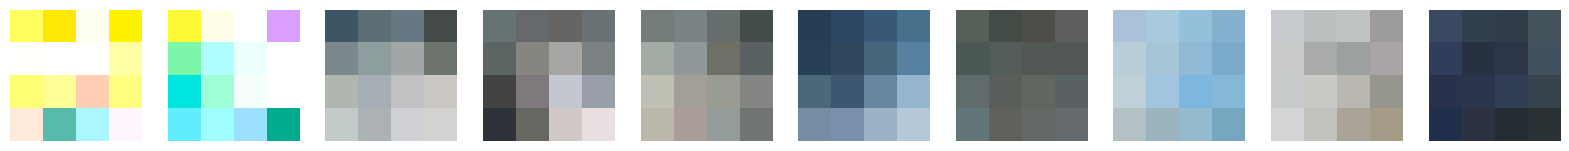

In [113]:
if(load_model):
    # Evaluate
    generate_examples(gen, 0, 2)
    generate_examples(gen, 1, 2)
    generate_examples(gen, 2, 2)
    generate_examples(gen, 3, 2)
    generate_examples(gen, 4, 2)

    # get directory
    cwd = os.getcwd()
    path = cwd + "/progan_examples"
    images = []

    # get all images
    for image in sorted(os.listdir(path)):
        image_path = os.path.join(path, image)
        img = cv2.imread(image_path)
        if(image is not None):
            images.append(img)
    
    train = list(map(preprocess, images))

    display(train[:10])

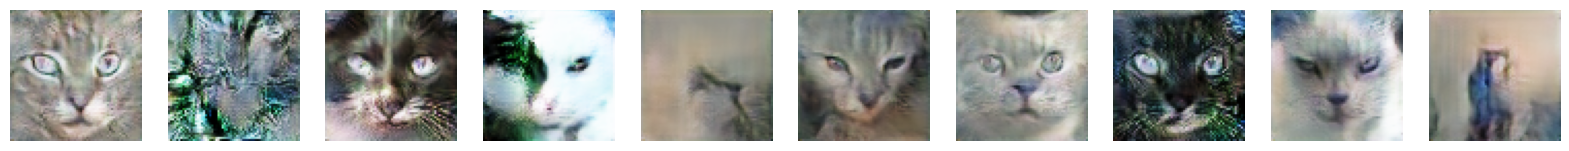

In [117]:
if(load_model):
    # get directory
    cwd = os.getcwd()
    path = cwd + "/progan_examples"
    images = []

    # remove all images
    for image in sorted(os.listdir(path)):
        image_path = os.path.join(path, image)
        os.remove(image_path)

    # Evaluate
    generate_examples(gen, 4, 10)

    # get all images
    for image in sorted(os.listdir(path)):
        image_path = os.path.join(path, image)
        img = cv2.imread(image_path)
        if(image is not None):
            images.append(img)
    
    train = list(map(preprocess, images))

    display(train[:10])